# Easy Machine Learning Example: Fruit Classification

This example uses data collected by Iain Murray from Edinburgh University on four different kinds of fruits. The data includes measures for mass, width, height, and a color scheme. The dataset is well known and often used for purposes of demonstration. This example uses some variations on other simple tutorials that I found useful (such as testing different models using few lines of code, and, most important, testing how a model performs on a new dataset). The code runs on Jupyter Notebook and libraries are the current ones from December 2020.

Import libraries and modules:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline

Import the Excel data file (in my case, the data is in a new folder "Data") and make a first exploratory data analysis. First, I am interested in the categegories (the fruits), which are labeled as 
*1 (for apples),
2 (for mandarins),
3 (for oranges) and 
4 (for lemons)*
In my dataset, somme values in the column "color" are missing. 

In [102]:
fruits = pd.read_excel('../../Data/fruits_missing.xlsx')

In [103]:
fruits.head(5)

,label,name,type,mass,width,height,color
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [109]:
fruits.shape

(59, 7)

A waterfall plot is a good option to show compositions of a variable, but not readily available in matplotlib or seaborn. I use the module "waterfallcharts" that needs to be installed as pip install first.

In [104]:
import waterfall_chart
import matplotlib.pyplot as plt

In [105]:
fruits['name'].value_counts()

apple       19
orange      19
lemon       16
mandarin     5
Name: name, dtype: int64

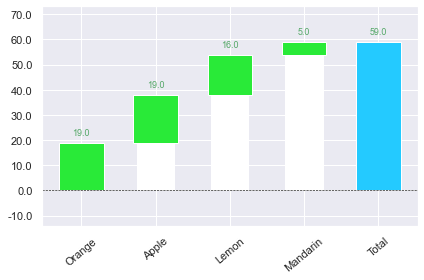

In [106]:
x = ["Apple", "Orange", "Lemon", "Mandarin" ]
y = [
    fruits.name.str.count("apple").sum(), 
    fruits.name.str.count("orange").sum(),
    fruits.name.str.count("lemon").sum(),
    fruits.name.str.count("mandarin").sum()]
waterfall_chart.plot(x, y, sorted_value=True, net_label="Total", rotation_value=40);

Before going any deeper into the analysis, I want to look for missing data in the remaining variables and replace missing data. I therefore need to remove the columns with strings first and save a new dataframe "fruits1". The module "missingno" (also needs to be installed first as pip install) gives a nice graph of missing data.

In [ ]:
fruits1 = fruits.drop(['name', 'type'], axis=1)

<AxesSubplot:>

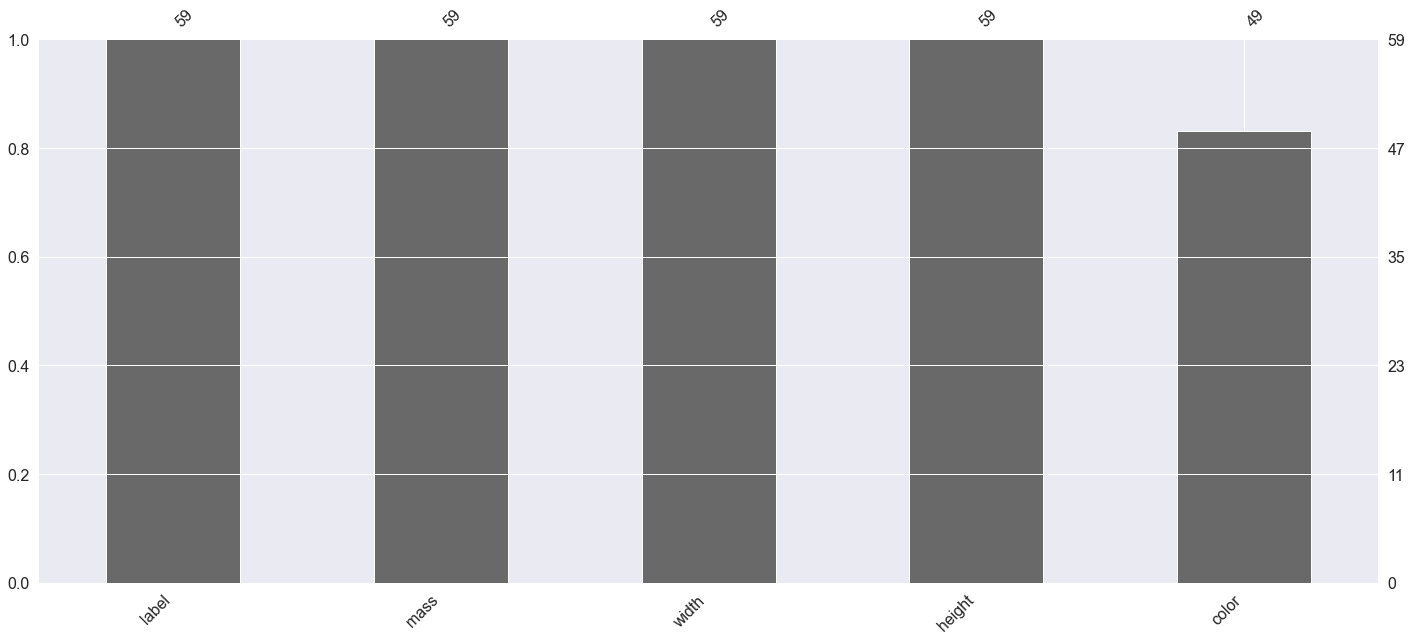

In [137]:
import missingno as msno
msno.bar(fruits1)

10 data fields are missing in the column "color". I will insert new data using the KNN imputer method. The imputed data is saved in the dataframe "fruits2"

In [141]:
imputer = KNNImputer(n_neighbors=5)
fruits_array = imputer.fit_transform(fruits1)
fruits2 = pd.DataFrame(fruits_array, columns=['label', 'mass', 'width', 'height', 'color']) 

<AxesSubplot:>

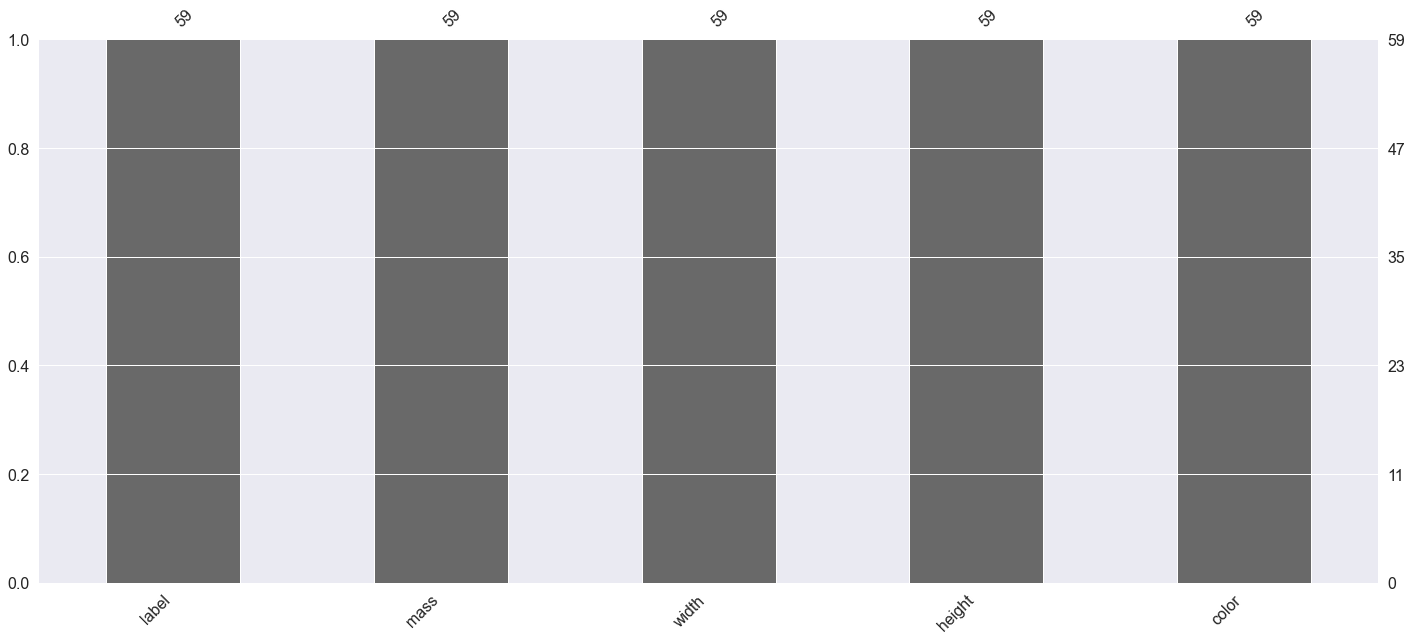

In [142]:
import missingno as msno
msno.bar(fruits2) 

"fruits2" will be used for further exploratory data analysis and modeling. "label" = 1.0 stands for apples, etc.  

In [145]:
fruits2.head(5)

,label,mass,width,height,color
0,1.0,192.0,8.4,7.3,0.55
1,1.0,180.0,8.0,6.8,0.59
2,1.0,176.0,7.4,7.2,0.60
3,2.0,86.0,6.2,4.7,0.80
4,2.0,84.0,6.0,4.6,0.79


Of all the available data analysis charts (boxplot, histogramn, etc.) the pairplot is I think the easiest and most practical way to analyse the data. The pairplot shows that "mass" makes a fairly good distinction between mandarins and appels/lemons, with some overlap for oranges. "Height" clearly seperates between mandarins and the rest, but the other fruits are clustered around the mean. "Color" makes no clear distinction, except that apples are distributed "all over the place". Probably only all variables taken together can perform the job.

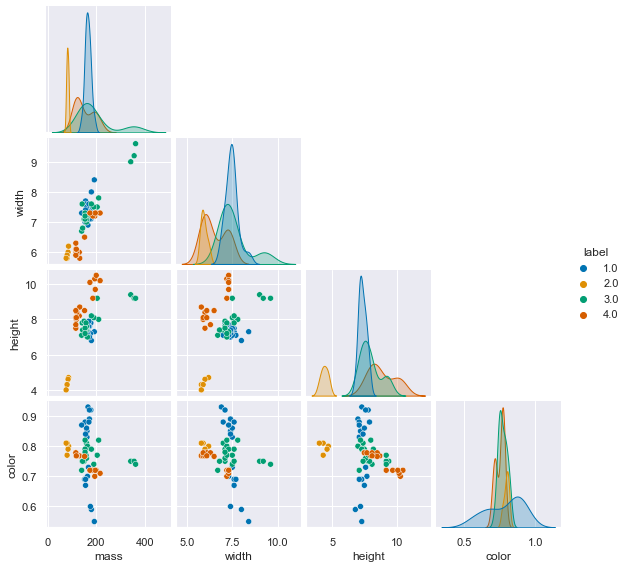

In [146]:
sns.pairplot(fruits2, hue="label", vars=["mass", "width", "height", "color"],  height = 2, palette = 'colorblind', corner=True)

A look at the cross-correlations of the variables confirms a strong positive relationship between mass and width. Since "color" is weakly correlated to the other variables, the variable could be dropped for the final models (I tested without "color", and results are slightly worse, so I keep the variable). 

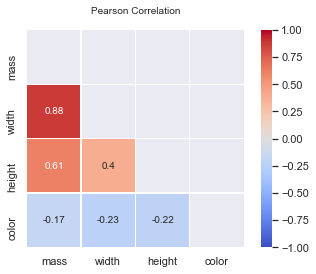

In [99]:
mask = np.triu(fruits2[["mass", "width", "height", "color"]].corr())
heatmap = sns.heatmap(fruits2[["mass", "width", "height", "color"]].corr(), vmin=-1, vmax=1, mask=mask, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.3)
heatmap.set_title('Pearson Correlation', fontdict={'fontsize':10}, pad=16);

After splitting the dataset, the data needs to be standardized (since "mass" and "color" have different scales compared to "width" and "height"). I use the standard preprocessor from scikit-learn to transform (scale) the data. Since I need the transformer later on again, I save it in file "sc.joblib" using joblib.  

In [116]:
train, test = train_test_split(fruits2, test_size = 0.2)

In [117]:
from sklearn.model_selection import train_test_split
x=fruits2[['mass', 'width', 'height', 'color']]
y=fruits2['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [118]:
from sklearn import preprocessing
import joblib
sc = preprocessing.scale
x_train = sc(x_train)
x_test = sc(x_test)
joblib.dump(sc, 'sc.joblib')

['sc.joblib']

I run a number of different classifiers, compare them afterwards, and select the best peforming classifier to classify new data. A note on "1234" used for some classifiers: The train_test_split method splits arrays into random train and test subsets. That means that every run of the model gives  a slightly different result. Fixing random_state = "some number" always gives the same result.

In [127]:
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(n_neighbors=3), 
               DecisionTreeClassifier(random_state=1234),
               LinearDiscriminantAnalysis(),
               RandomForestClassifier(random_state=1234),
               SVC(gamma='auto')]

In [128]:
results_table = pd.DataFrame(columns=['classifiers', 'accuracy', 'wrong_detection'])

In [129]:
for cls in classifiers:
    model = cls.fit(x_train, y_train)
    prediction=model.predict(x_test)
    accuracy = metrics.accuracy_score(prediction,y_test)
    wrong_detection = np.where(prediction != y_test) 
    
    
    results_table = results_table.append({'classifiers':cls.__class__.__name__,
                                        'accuracy':accuracy,
                                         'wrong_detection':wrong_detection}, ignore_index=True)
results_table.set_index('classifiers', inplace=True)

results_table

,accuracy,wrong_detection
classifiers,,
LogisticRegression,0.466667,"([1, 3, 4, 6, 8, 11, 12, 13],)"
GaussianNB,0.466667,"([1, 3, 6, 8, 9, 12, 13, 14],)"
KNeighborsClassifier,0.933333,"([3],)"
DecisionTreeClassifier,0.733333,"([3, 6, 9, 13],)"
LinearDiscriminantAnalysis,0.600000,"([0, 4, 5, 6, 11, 13],)"
RandomForestClassifier,0.800000,"([3, 5, 6],)"
SVC,0.933333,"([3],)"


For this data, KNN and SVC turn out to be the most accurate classifiers. An alternative to the table is a confusion matrix (here shown for all classifiers). 

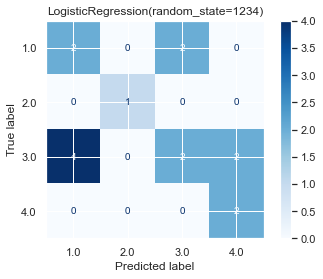

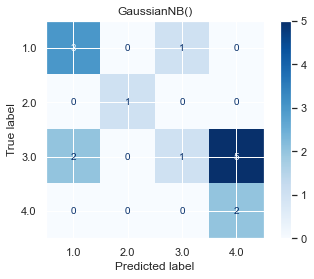

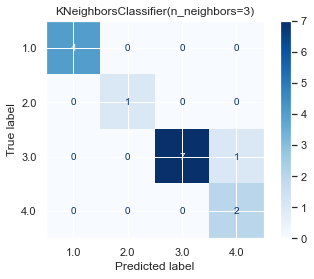

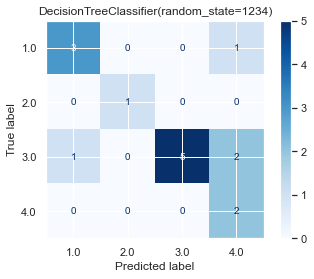

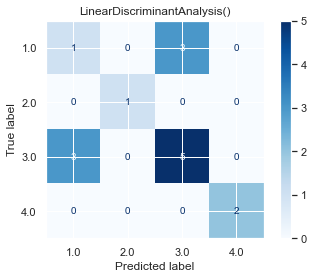

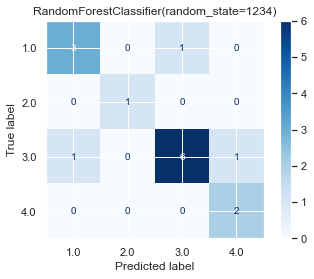

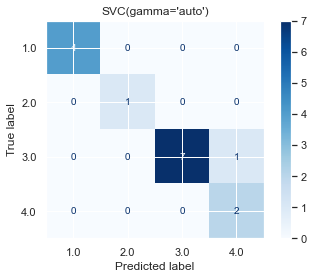

In [130]:
from sklearn.metrics import plot_confusion_matrix
for cls in classifiers:
    model = cls.fit(x_train, y_train)
    prediction=model.predict(x_test)
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.title(cls)    
plt.show()


The last but very important step is to run the classifier on new dataset. I made up a new small dataset just to demonstrate and see how the classifier (in this case the KNN) predicts the fruit for each sample (again, 1=apple, etc.)

In [131]:
fruits_new = pd.read_excel('../../Data/data_fruits_new.xlsx')
fruits_new

,mass,width,height,color
0,190,8.0,7,0.60
1,185,8.2,7,0.65
2,180,6.0,7,0.69
3,80,6.0,4,0.80


In [132]:
sc = joblib.load('sc.joblib')
fruits_new = sc(fruits_new)

model = KNeighborsClassifier().fit(x_train, y_train)
prediction=model.predict(fruits_new)
print(prediction)

[1. 1. 4. 2.]


In addition, I can check if the KNN could perform even better with a different value of "k" (I chose the value 3 initially just to start. As it turns out, a value of 3 yields the best testing accurary. 

Text(0, 0.5, 'Testing Accuracy')

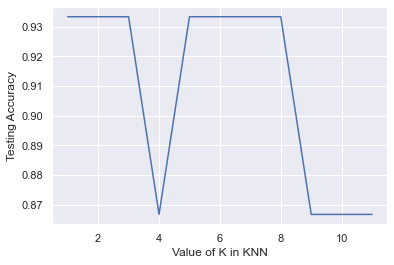

In [134]:
k_range = range (1,12)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))

plt.plot(k_range,scores_list)
plt.xlabel("Value of K in KNN")
plt.ylabel("Testing Accuracy")